# Association Rule Mining for reported street crimes in England & Wales
The aim here is to see if there are any associations between the reported aspects of street crime, such as Month of Year, Location, Crime type etc.
This will be done in Pyspark due to the size of the data but it will still be possible to execute on a local cluster.

The data can be downloaded from here: https://data.police.uk/data/.

The date range for this data is December 2010 - July 2019 and all constabularies in England & Wales were selected (we will be excluding British Transport Police and Police Service of Northern Ireland)

## What is an Association Rule?
*Association rule learning is a rule-based machine learning method for discovering interesting relations between variables in large databases. It is intended to identify strong rules discovered in databases using some measures of interestingness. This rule-based approach also generates new rules as it analyzes more data. The ultimate goal, assuming a large enough dataset, is to help a machine mimic the human brain’s feature extraction and abstract association capabilities from new uncategorized data.*

We will be looking for rules with a high level of confidence

*Confidence is an indication of how often the rule has been found to be true... Confidence can be interpreted as an estimate of the conditional probability*

In [1]:
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import seaborn as sns

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Set up Spark
Running Spark locally using 6 out of 8 cores

In [3]:
from pyspark import SparkContext
from pyspark.sql import SQLContext, SparkSession

In [4]:
spark = SparkSession.builder\
        .master("local[7]")\
        .appName("Crime Assocations")\
        .config("spark.executor.memory", "6g")\
        .config("spark.memory.fraction", 0.7)\
        .getOrCreate()

In [5]:
sc = spark.sparkContext
# Set up a SQL Context
sqlCtx = SQLContext(sc)

In [94]:
#sc.stop()

## Load Data into Spark

In [6]:
from p01_load import load_data

The police data comes in several csv files with a folder for each Month-Year. Within each folder, there is a CSV file for each constabulary. We will concatenate these

In [7]:
path = glob.glob(os.getcwd() + "/all_data/*/*-street.csv")

In [8]:
police_data_df = load_data(file_locations=path, sqlcontext=sqlCtx)

Loading CSV files to sqlcontext...
Load Complete


#### Inspecting the data

In [10]:
police_data_df.select(police_data_df.columns[1:]).show()

+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
|  Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|           LSOA name|          Crime type|Last outcome category|Context|
+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
|2012-08|Metropolitan Poli...|Metropolitan Poli...|-0.508053|50.809718|On or near Claigm...|E01031464|           Arun 007F|       Violent crime|  Under investigation|   null|
|2012-08|Metropolitan Poli...|Metropolitan Poli...| -1.01393|51.899297|On or near St Mic...|E01017673| Aylesbury Vale 010C|         Other crime|  Under investigation|   null|
|2012-08|Metropolitan Poli...|Metropolitan Poli...| 0.964612|52.045416|On or near Barnes...|E01029896|        Babergh 004E|  

Each dataset contains the following columns:

In [13]:
police_data_df.printSchema()

root
 |-- Crime ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported by: string (nullable = true)
 |-- Falls within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA code: string (nullable = true)
 |-- LSOA name: string (nullable = true)
 |-- Crime type: string (nullable = true)
 |-- Last outcome category: string (nullable = true)
 |-- Context: string (nullable = true)



The Data Dictionary is as follows

In [10]:
dictionary = pd.read_csv('data_dictionary.csv')

In [11]:
pd.set_option('display.max_colwidth', -1)
for elem in dictionary.to_records(index=False):
    print(elem[0] + ": " + elem[1])

Reported by: The force that provided the data about the crime.
Falls within: At present, also the force that provided the data about the crime. This is currently being looked into and is likely to change in the near future.
Longitude and Latitude: The anonymised coordinates of the crime. See Location Anonymisation for more information.
LSOA code and LSOA name: References to the Lower Layer Super Output Area that the anonymised point falls into, according to the LSOA boundaries provided by the Office for National Statistics.
Crime type: One of the crime types listed in the Police.UK FAQ.
Last outcome category: A reference to whichever of the outcomes associated with the crime occurred most recently. For example, this crime's 'Last outcome category' would be 'Formal action is not in the public interest'.
Context: A field provided for forces to provide additional human-readable data about individual crimes. Currently, for newly added CSVs, this is always empty.


NOTE: LSOA (Lower Layer Super Output Area)

From NHS Data Dictionary (https://www.datadictionary.nhs.uk/data_dictionary/nhs_business_definitions/l/lower_layer_super_output_area_de.asp?shownav=1)
    
"<i>A Lower Layer Super Output Area (LSOA) is a GEOGRAPHIC AREA.
Lower Layer Super Output Areas are a geographic hierarchy designed to improve the reporting of small area statistics in England and Wales.
Lower Layer Super Output Areas are built from groups of contiguous Output Areas and have been automatically generated to be as consistent in population size as possible, and typically contain from four to six Output Areas. The Minimum population is 1000 and the mean is 1500.
There is a Lower Layer Super Output Area for each POSTCODE in England and Wales</i>"

How many Rows do we have?

In [14]:
num_rows = police_data_df.count()

In [14]:
num_rows

52835178

## Cleaning the Data

In [9]:
from p02_clean import clean_months, clean_location, clean_non_england

In [10]:
# The month column in the data is actually a Year-Month, here we will split that on the - delimiter and create a Year and Month_of_Year Column
police_data_clean = clean_months(police_data_df)
# Now lets create a Location and Town/City Column
police_data_clean = clean_location(police_data_clean)
police_data_clean = clean_non_england(police_data_clean)

Cleaning Year and Month Columns...
Creating Month_of_Year and Year columns...
Cleaning Complete
Cleaning Location and Town and City...
Cleaning Complete
Removing non England and Wales entries
Removal Complete


In [11]:
police_data_clean.printSchema()

root
 |-- Crime ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported by: string (nullable = true)
 |-- Falls within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA code: string (nullable = true)
 |-- LSOA name: string (nullable = true)
 |-- Crime type: string (nullable = true)
 |-- Last outcome category: string (nullable = true)
 |-- Context: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month_of_Year: string (nullable = true)
 |-- Town_City: string (nullable = true)



## Exploratory Analysis

In [12]:
import pyspark.sql.functions as F

In [14]:
import p03_eda as eda

#### Are there any cases of when the constabulary that reported the crime is different to the constabulary area?

In [21]:
police_data_clean\
    .where(F.col("Reported by") != F.col("Falls within"))\
    .count()

0

#### Number of Incidents over time

Setting Month to a categorical variable...
Setting complete
Converting to Series object...
Conversion complete
Creating plot object
Complete.. Plotting...


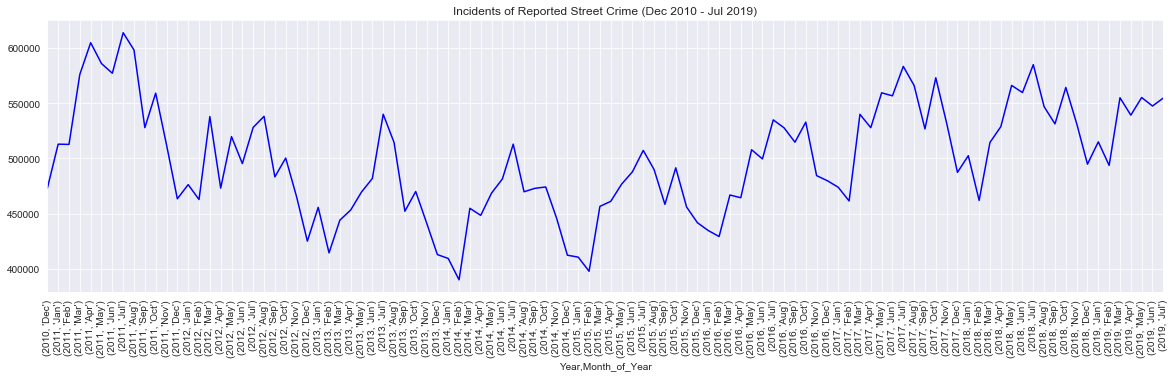

In [15]:
plt.figure(figsize=(20, 5))
crime_over_time_plot = eda.plot_crime_time_series(police_data_clean, read=True)
plt.show()

There appears to be a stationary trend with some periodicity with the numbers of reported crimes, although we do not have complete years in this dataset. It looks like there is a pattern to the level/numbers of street crimes!

#### Most Common Crime and Outcome Category Combination

Converting to Series
Collapsing Multi Index
Plotting...


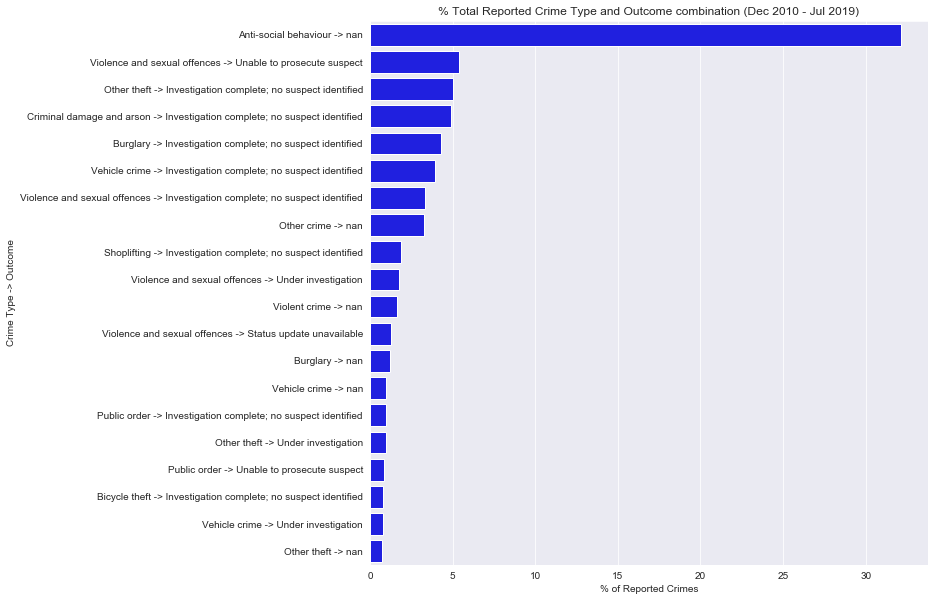

In [20]:
plt.figure(figsize=(10, 10))
outcome_category_plot = eda.plot_crime_type_and_category_counts(police_data_clean, read=True)
plt.show()

It seems the most common type to outcome association is an anti social behaviour crime with no recorded outcome

#### The Most Common Type of Crime

Converting to Series object...
Plotting...


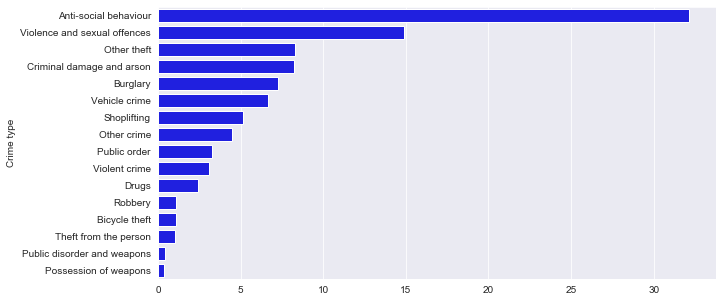

In [29]:
plt.figure(figsize=(10, 5))
crime_type_plot = plot_crime_counts(police_data_clean, read=True)
plt.show()

Anti-social behaviour makes up about 35% of crime in England - which is expected... It is concerning that violence and sexual offences is in second place

#### Which Town or City has the most crime?

Converting to Series
Plotting...


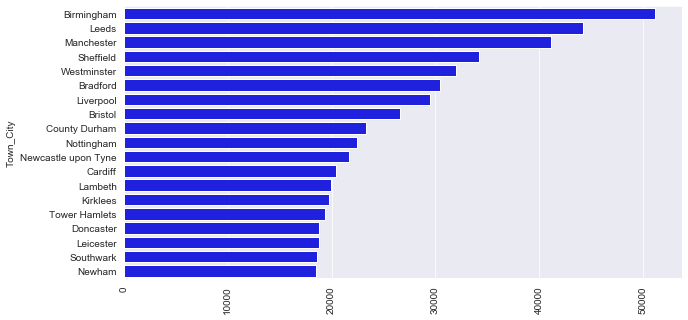

In [31]:
plt.figure(figsize=(10,5))
crime_town_city_counts = plot_crime_town_city_counts(police_data_clean, read=True)
plt.xticks(rotation=90)
plt.show()

## Feature Engineering

Let's look at what the feature engineering code is actually doing

In [67]:
%%bash
cat p04_feature_engineer.py

import pyspark.sql.functions as F
from pyspark.sql.types import ArrayType, StringType

clear_duplicates = F.udf(lambda x: list(set(x)), ArrayType(StringType()))

def get_modelling_data(df):
    
    select_cols = ["Falls within", "Town_City", "Crime type", "Last outcome category", "Month_of_Year"]
    
    # Remove the crimes with no crime ID and no LSOA Information.
    # Then select the features of interest
    
    print('Filtering data with no Crime ID...')
    police_data_modelling = df\
        .filter(df["Crime ID"].isNotNull() & df["Last outcome category"].isNotNull())\
        .select(select_cols)
    print('Filtering complete')
    return police_data_modelling

def make_item_sets(df):
    # The FP growth algorithm (like association rules), needs the items to be concatenated into a list/array of "transactions".
    print('Making item sets...')
    print('Collapsing data to list of transactions')
    police_item_set = df.withColumn("items_temp", F.array(df["Falls within"],
    

In [13]:
from p04_feature_engineer import *

In [14]:
# Remove the crimes with no crime ID and no LSOA Information.
police_item_set = feature_engineer(police_data_clean)

Starting Feature Engineering pipeline...
Filtering data with no Crime ID and no outcome category..
Filtering complete
Making item sets...
Collapsing data to list of transactions
Adding increasing id column...
Itemset creation complete
Feature Engineering complet


The FP growth algorithm (like association rules), needs the items to be concatenated into a list/array of "transactions".

In [15]:
police_item_set.show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------+
|items                                                                                                                             |
+----------------------------------------------------------------------------------------------------------------------------------+
|[Metropolitan Police Service, Aug, Arun, Violent crime, Under investigation]                                                      |
|[Other crime, Metropolitan Police Service, Aug, Aylesbury Vale, Under investigation]                                              |
|[Metropolitan Police Service, Aug, Violent crime, Under investigation, Babergh]                                                   |
|[Burglary, Barking and Dagenham, Metropolitan Police Service, Aug, Under investigation]                                           |
|[Barking and Dagenham, Metropolitan Police Service, Investigation co

## Modelling: Create the FP growth algorithm
For Association rules

In [16]:
from p05_model import build_association_rule_model, extract_model_rules

In [17]:
# Use a low support as we have a large dataset
model = build_association_rule_model(police_item_set, min_support=0.01, min_confidence=0.6)

Fitting FPGrowth....
Fit Complete


#### Extract the Association Rules

In [19]:
rules_df_pd = extract_model_rules(model)

Extracting Rules...
Rule extraction complete
Collection Complete...


In [20]:
rules_df_pd

,antecedent,consequent,confidence,lift
0,Theft from the person,Investigation complete; no suspect identified,0.601021,1.274382
1,Greater Manchester Police,Investigation complete; no suspect identified,0.603717,1.280098
2,West Midlands Police,Investigation complete; no suspect identified,0.606495,1.285988
3,Birmingham,Investigation complete; no suspect identified,0.607874,1.288914
4,"Birmingham,West Midlands Police",Investigation complete; no suspect identified,0.608291,1.289796
5,Unable to prosecute suspect,Violence and sexual offences,0.621860,2.453091
6,Criminal damage and arson,Investigation complete; no suspect identified,0.641662,1.360556
7,Manchester,Investigation complete; no suspect identified,0.650860,1.380060
8,"Manchester,Greater Manchester Police",Investigation complete; no suspect identified,0.651027,1.380413
9,Other theft,Investigation complete; no suspect identified,0.666711,1.413669


In [21]:
rules_df_pd.to_csv('crime_associations.csv')

In [22]:
# Stop the Spark Session
sc.stop()

## Rules Analysis
As you can see, the rules in the 98%+ confidence region appear to be rules that don't really tell us anything. i.e. Birmingham -> West Midlands Police. Let's remove those from the analysis

In [23]:
useful_rules_df = rules_df_pd[rules_df_pd['confidence'] < 0.98]\
    .sort_values(by="confidence", ascending = False)

In [24]:
useful_rules_df

,antecedent,consequent,confidence,lift
12,Bicycle theft,Investigation complete; no suspect identified,0.719270,1.525113
11,Burglary,Investigation complete; no suspect identified,0.711254,1.508117
10,Vehicle crime,Investigation complete; no suspect identified,0.692018,1.467329
9,Other theft,Investigation complete; no suspect identified,0.666711,1.413669
8,"Manchester,Greater Manchester Police",Investigation complete; no suspect identified,0.651027,1.380413
7,Manchester,Investigation complete; no suspect identified,0.650860,1.380060
6,Criminal damage and arson,Investigation complete; no suspect identified,0.641662,1.360556
5,Unable to prosecute suspect,Violence and sexual offences,0.621860,2.453091
4,"Birmingham,West Midlands Police",Investigation complete; no suspect identified,0.608291,1.289796
3,Birmingham,Investigation complete; no suspect identified,0.607874,1.288914


Now the rule with the highest confidence is **(Bicycle Theft -> Investigation complete; no suspect identified)**. So what does this mean? This means that given that a crime is a Bike Theft, the probability the investigation will be complete with no suspect identified is around 72%

The other 3 rules in the 65%+ confidence/conditional probability region follow a similar pattern.
- **(Other theft -> Investigation complete; no suspect identified)**
- **(Burglary -> Investigation complete; no suspect identified)**
- **(Vehicle Crime -> Investigation complete; no suspect identified)**

So, it implies that the probability of no suspect being identified after a burglary, vehicle crime, an incident of criminal damage or arr is about 69-72%.

Another interesting rule is **(Manchester -> Investigation complete; no suspect identified)**. So what this is saying is, the model estimates that the probability that a reported crime leads to a complete investigation with no suspect identified, given that the crime occurred in Manchester around 65%

Another block of these rules is **(Unable to prosecute suspect -> Violence and sexual offences)**, which sounds worrying but doesn't really say much. The conditional probability of a crime being a violence and sexual offence, given that you were unable to prosecute the suspect is around 61%.

In [32]:
sc.stop()